# Problem 8 (20 Points)

## Problem Description

Several molecular dynamics simulations have been carried out for a material, and the phase (solid/liquid/vapor) at different temperature/pressure combinations has been recorded.

You will use gradient descent to train a One-vs-Rest logistic regression model on data with 3 classes. Fill out the notebook as instructed, making the requested plots and printing necessary values. 

*You are welcome to use any of the code provided in the previous problems.*

#### Summary of deliverables:
- 3 binomial classification `w` vectors, corresponding to each class
- Function `classify(xy)` that evaluates all 3 models at a given array of points, returning the class prediction as the model with the highest probability
- Print model percent classification accuracy on the training data
- Print model percent classification accuracy on the testing data
- Plot that shows the training data as data points, along with the class of a grid of points in the background, as in the lecture activity.

### Imports and Utility Functions:

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_data(x, y, c,title="Phase of simulated material"):
    xlim = [0,52.5]
    ylim = [0,1.05]
    markers = [dict(marker="o", color="royalblue"), dict(marker="s", color="crimson"), dict(marker="^", color="limegreen")]
    labels = ["Solid", "Liquid", "Vapor"]

    plt.figure(dpi=150)

    for i in range(1+max(c)):
        plt.scatter(x[c==i], y[c==i], s=60, **(markers[i]), edgecolor="black", linewidths=0.4,label=labels[i])

    plt.title(title)
    plt.legend(loc="upper right")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Temperature, K")
    plt.ylabel("Pressure, atm")
    plt.box(True)

def plot_colors(classify, res=40):
    xlim = [0,52.5]
    ylim = [0,1.05]
    xvals = np.linspace(*xlim,res)
    yvals = np.linspace(*ylim,res)
    x,y = np.meshgrid(xvals,yvals)
    XY = np.concatenate((x.reshape(-1,1),y.reshape(-1,1)),axis=1)

    color = classify(XY).reshape(res,res)

    cmap = ListedColormap(["lightblue","lightcoral","palegreen"])
    plt.pcolor(x, y, color, shading="nearest", zorder=-1, cmap=cmap,vmin=0,vmax=2)
    return

## Load Data
This cell loads the dataset into the following variables:
- `train_data`: Nx2 array of input features, used for training
- `train_gt`: Array of ground-truth classes for each point in `train_data`
- `test_data`: Nx2 array of input features, used for testing
- `test_gt`: Array of ground-truth classes for each point in `test_data`

In the class arrays, 0 = solid, 1 = liquid, 2 = vapor.

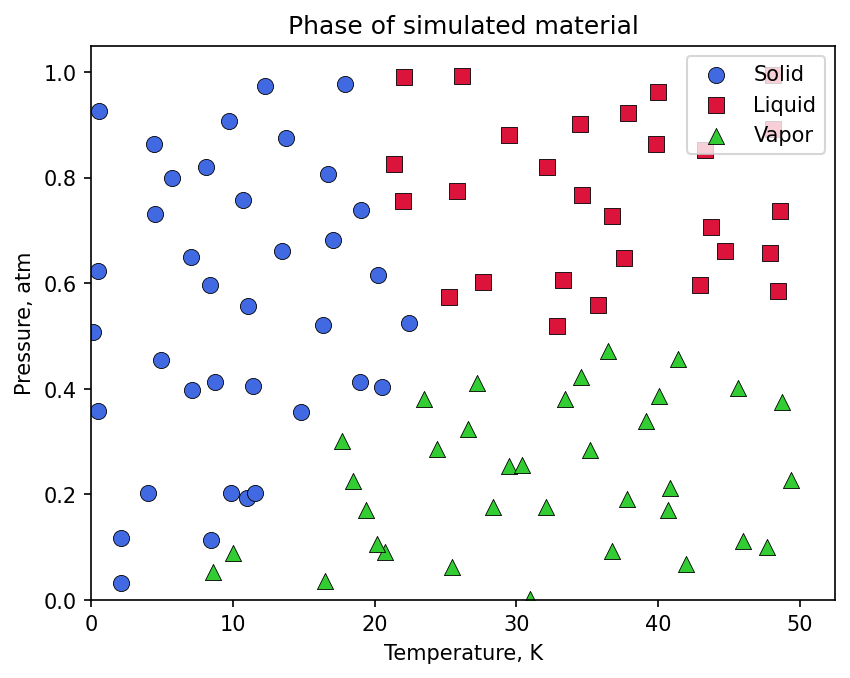

In [27]:
train = np.load("data/w3-hw2-data-train.npy")
test = np.load("data/w3-hw2-data-test.npy")
train_data, train_gt = train[:,:2], train[:,2].astype(int)
test_data, test_gt = test[:,:2], test[:,2].astype(int)
plot_data(train_data[:,0], train_data[:,1],train_gt)

## Gradient Descent

Here, write all of the necessary code to perform gradient descent and train 3 logistic regression models for a 1-vs-rest scenario. Use linear decision boundaries (features should only be 1, temperature, pressure)


Feel free to reuse code from the first problem or lecture activities.

We have provided the following function to help with the one-vs-all method:  

`convert_to_binary_dataset(classes, A)`:
- Input: data, Nx2 array of temperature-pressure data
- Input: classes, array (size N) of class values for each point in `data`
- Input: A, the class (0, 1, or 2 here) to use as '1' in the binary dataset
- Returns: `classes_binary`, copy of classes where class A is 1, and all other classes are 0.



In [28]:
def convert_to_binary_dataset(classes, A):
    classes_binary = (classes == A).astype(int)
    return classes_binary

In [29]:
def sigmoid(h):
    return (np.divide(1, (np.add(np.exp(-h), 1))))

def transform(data, w):
    xs = data[:,0]
    ys = data[:,1]
    ones = np.ones_like(xs)
    h = w[0]*ones + w[1]*xs + w[2]*ys
    return h

def loss(data, y, w):
    wt_x = transform(data,w)
    J1 = -np.log(sigmoid(wt_x)) * y
    J2 = -np.log(1-sigmoid(wt_x))*(1-y)
    L = np.sum(J1 + J2)
    return L

def gradloss(data, y, w):
    wt_x = transform(data,w)
    return np.array([np.sum((sigmoid(wt_x) - y) * np.ones(len(data[:,0]))), np.sum((sigmoid(wt_x) - y) * data[:,0]), np.sum((sigmoid(wt_x) - y) * data[:,1])])

def grad_desc(data, y, w0=np.array([0,0,0]), iterations=100, stepsize=0.1):
    for i in range(iterations):
        w0 = w0 - np.multiply(stepsize,gradloss(data,y,w0))
    return w0

# Training
Train your 3 models and print the `w` vector corresponding to each class

In [55]:
# def get_ovr_prob_function(xy, c, A, iterations=100, stepsize=0.1):
#     c_new = (c == A).astype(int)
    
#     w = grad_desc(xy,c_new, iterations=100, stepsize=0.1)
#     print("Class ", A, " w: ", w, r"%")

#     def prob(xy):
#         pred = np.round(sigmoid(transform(xy, w))).astype(int)
#         return pred.flatten()
    
#     return prob
from sklearn.linear_model import LogisticRegression

def get_ovr_prob_function(xy, c, A):
    c_new = (c == A).astype(int)
    
    model = LogisticRegression(max_iter=10000, tol=1e-6, C=10)
    model.fit(xy,c_new)

    def prob(xy):
        pred = model.predict_proba(xy)[:,1]
        return pred.flatten()
    
    return prob

def generate_ovr_prob_functions(xy, c):
    A = np.unique(c)
    classifier_list = []
    for A_i in A:
        classifier_list.append(get_ovr_prob_function(xy, c, A_i))
    return classifier_list

probs = generate_ovr_prob_functions(train_data, train_gt)

## Classification function
Write a function `classify(xy)` that will evaluate each model and select the appropriate class.


In [56]:
def classify(xy):
    results = []
    for prob in probs:
        results.append(prob(xy))
    
    results = np.array(results)
    maximum = np.max(results, axis=0)
    return np.array([np.where(results[:,i] == maximum[i])[0] for i in range(len(maximum))]).flatten()

## Accuracy
Compute and print the accuracy on the training and testing sets as a percent

In [57]:
train_preds = classify(train_data)
test_preds = classify(test_data)
train_accuracy = np.sum(train_preds == train_gt) / len(train_gt) * 100
test_accuracy = np.sum(test_preds == test_gt) / len(test_gt) * 100
print("    Train Accuracy: ", train_accuracy, r"%")
print("    Test Accuracy: ", test_accuracy, r"%")

    Train Accuracy:  94.0 %
    Test Accuracy:  92.0 %


## Plot results
Run this cell to visualize the data along with the results of `classify()`

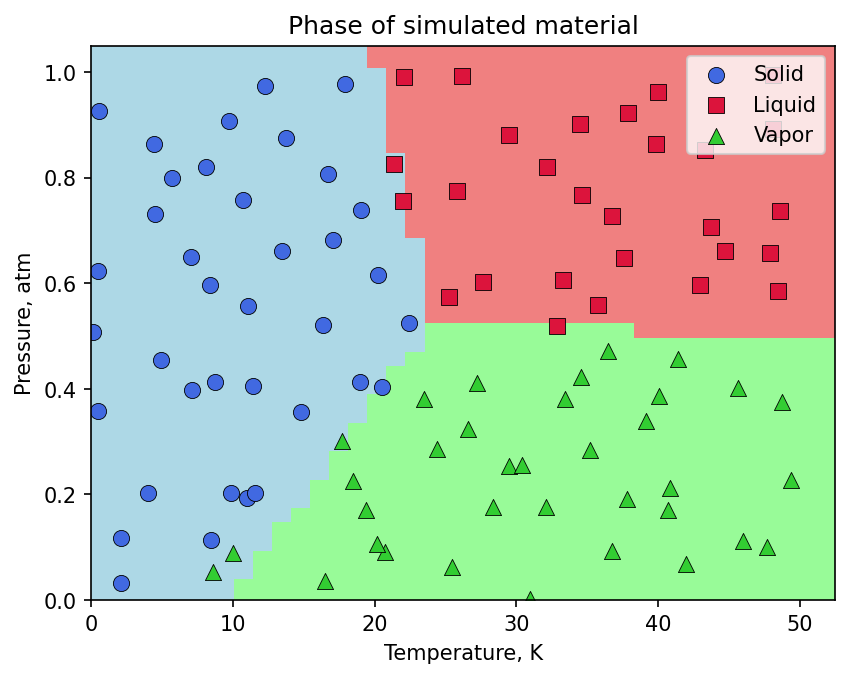

In [58]:
plot_data(train_data[:,0], train_data[:,1], train_gt)
plot_colors(classify)